![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Part 1: Text Analysis


For each of the hotels extract the text on the description (and possibly other text
metadata) and do the following:

1. Pre-process the text by removing stop words and stemming. Customize your
stopword list if needed.
2. Create two wordclouds before and after pre-processing for each city (a total of
four). Comment on the changes in the wordclouds.


**Chosen event**: Mobile World Congress (3rd to 6th March in 2025).

## 0. Packages

In [81]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [82]:
import re
import nltk
import spacy
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Download NLTK data (if needed)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

## 1. File Load

We are going to two main files:

**General Results:** A collection of files following the format `results_YYYY-MM-DD&YYYY-MM-DD_City.csv`, where:

`YYYY-MM-DD` represents the start and end dates of the dataset.
City indicates the location for which the data was collected.

Information of city and dates are included in the dataset as new fields.

**Hotel Descriptions File:** The file `descriptions_5452.csv` contains scraped text descriptions for each hotel. This dataset serves as the primary text source for our analysis.

In [83]:
import pandas as pd
import re
import os

# Define the path where the CSV files are located
csv_directory = os.path.join(os.getcwd(), "files", "general_results")

df = pd.read_csv("mental_health.csv")

df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


We filter the hotel data for two specific weeks: February 9th to 16th and March 1st to 8th, covering both Madrid and Barcelona.

Then, we filter the data to keep only the hotels that appear in both time periods for each city. This way, we focus on hotels that have consistent availability, making our analysis more reliable.

In [84]:
df_filtered_0 = df[df["label"] == 0]
df_filtered_1 = df[df["label"] == 1]
df_filtered_1.head()


,text,label
1,nothing look forward lifei dont many reasons k...,1
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
5,hey rredflag sure right place post this goes ...,1
7,deserve liveif died right noone would carei re...,1


## 2. Pre-processing

The text data is cleaned and prepared by removing stopwords, tokenizing, and applying stemming to standardize word forms. Below some functions are defined to achieve this goal.

In [85]:
# Load spaCy model
sp = spacy.load("en_core_web_sm")

# Load previous preprocessing functions
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

STOP_WORDS = set(stopwords.words('english'))

# Custom stop words related to the cities and some hotel terms
custom_stopwords = {
"im",
"like",
"want",
"know",
"get", 
"one", 
"me",
"even","got", "ive","make", "think", "tought"
}
STOP_WORDS.update(custom_stopwords)


def remove_initial_paragraph(text):
    #build the expression
    pattern = re.compile(r'The Security Council\s?,')
    #test the expression
    match = pattern.search(text)
    # we basically want to use this as a splitter and remove everything before it
    if match:
        return text[match.end():]
    else:
        #might wanna print somwthing here but we've already checked it.
        return text        

def preprocess_lower(text):
    
    # Lowercase the text
    text_lower = text.lower()

    # Remove punctuation (everything except word characters and whitespace)
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)

    # Tokenize the cleaned text.
    tokens = word_tokenize(text_no_punct)

    # Filter out stopwords.
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]

    return " ".join(filtered_tokens)


def preprocess_stem(text):

    # Get the cleaned lowercased and stopwords-removed tokens.
    joined_tokens = preprocess_lower(text)
    
    tokens=word_tokenize(joined_tokens)

    # Initialize the Porter Stemmer.
    ps = PorterStemmer()

    # Stem each token.
    stemmed_tokens = [ps.stem(token) for token in tokens]

    return " ".join(stemmed_tokens)


def preprocess_lemma(text):

    # Process text using spaCy
    doc = sp(text)

    # Extract the lemma of each token, filtering out tokens flagged as punctuation or stopwords.
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']

    return " ".join(lemmatized_tokens)


def tokenize(text, mode=0):

    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")

Applying preprocessing functions to description field in dataframe.

In [86]:
# Apply preprocessing functions to the DataFrame
df['text_no_stopwords'] = df['text'].apply(lambda x: preprocess_lower(x) if pd.notna(x) else "")
df['text_stem'] = df['text_no_stopwords'].apply(lambda x: preprocess_stem(x) if pd.notna(x) else "")

df

,text,label,text_no_stopwords,text_stem
0,dear american teens question dutch person hear...,0,dear american teens question dutch person hear...,dear american teen question dutch person heard...
1,nothing look forward lifei dont many reasons k...,1,nothing look forward lifei dont many reasons k...,noth look forward lifei dont mani reason keep ...
2,music recommendations im looking expand playli...,0,music recommendations looking expand playlist ...,music recommend look expand playlist usual gen...
3,im done trying feel betterthe reason im still ...,1,done trying feel betterthe reason still alive ...,done tri feel betterth reason still aliv mum d...
4,worried year old girl subject domestic physic...,1,worried year old girl subject domestic physica...,worri year old girl subject domest physicalmen...
...,...,...,...,...
27972,posting everyday people stop caring religion ...,0,posting everyday people stop caring religion m...,post everyday peopl stop care religion matter ...
27973,okay definetly need hear guys opinion ive pret...,0,okay definetly need hear guys opinion pretty m...,okay definetli need hear guy opinion pretti mu...
27974,cant get dog think ill kill myselfthe last thi...,1,cant dog ill kill myselfthe last thing holding...,cant dog ill kill myselfth last thing hold yup...
27975,whats point princess bridei really think like ...,1,whats point princess bridei really wesley said...,what point princess bridei realli wesley said ...


### 3. World Clouds

Here, we generate word clouds for each city to visualize the most frequent words.

In [87]:
# Define a function to generate word clouds for each city
def generate_wordclouds(df, text_column):
    label_corpus = {}
    
    # Iterate through each unique city in the dataset
    for label in df['label'].unique():
        # Filter descriptions by label
        text_corpus = " ".join(df[df['label'] == label][text_column].dropna())
        
        # Store the processed text in the dictionary
        label_corpus[label] = text_corpus
    
    # Generate and display word clouds side by side
    num_label = len(label_corpus)
    fig, axes = plt.subplots(1, num_label, figsize=(10 * num_label, 5))
    
    if num_label == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one city
    
    for ax, (label, text) in zip(axes, label_corpus.items()):
        if text.strip():  # Ensure the text is not empty
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white', 
                colormap='viridis', 
                max_words=100
            ).generate(text)
            
            # Display the word cloud
            ax.imshow(wordcloud, interpolation="bilinear")
            ax.axis("off")  # Remove axes
            ax.set_title(f"Word Cloud for {label}")
    
    plt.show()



### 3.1 World Cloud Before Pre-Processing

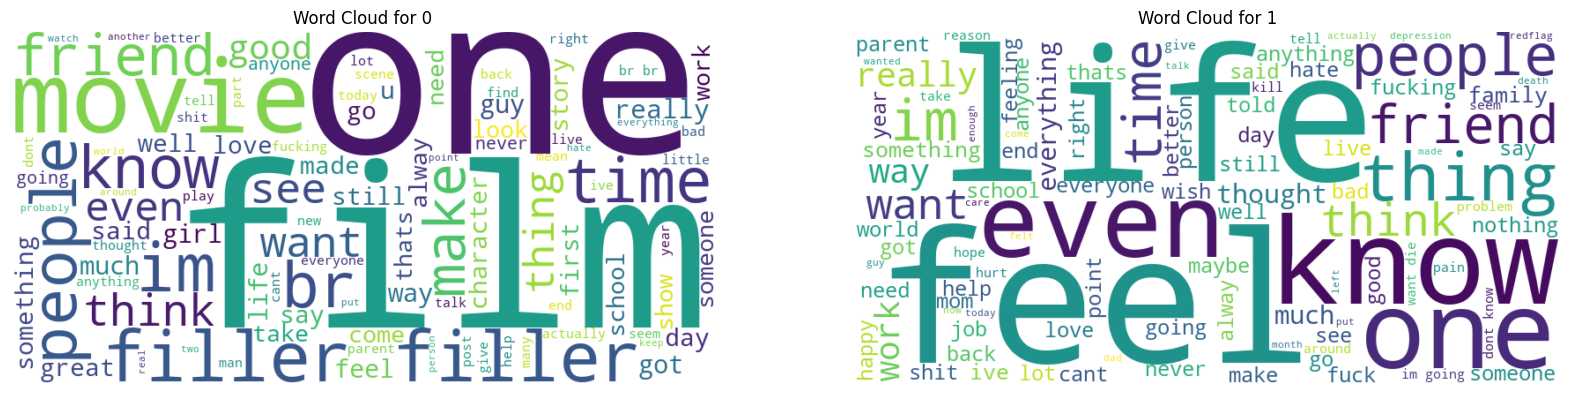

In [88]:
# Generate word clouds before pre-processing
generate_wordclouds(df, 'text')

### 3.2. Word clouds After Stopwords Removal

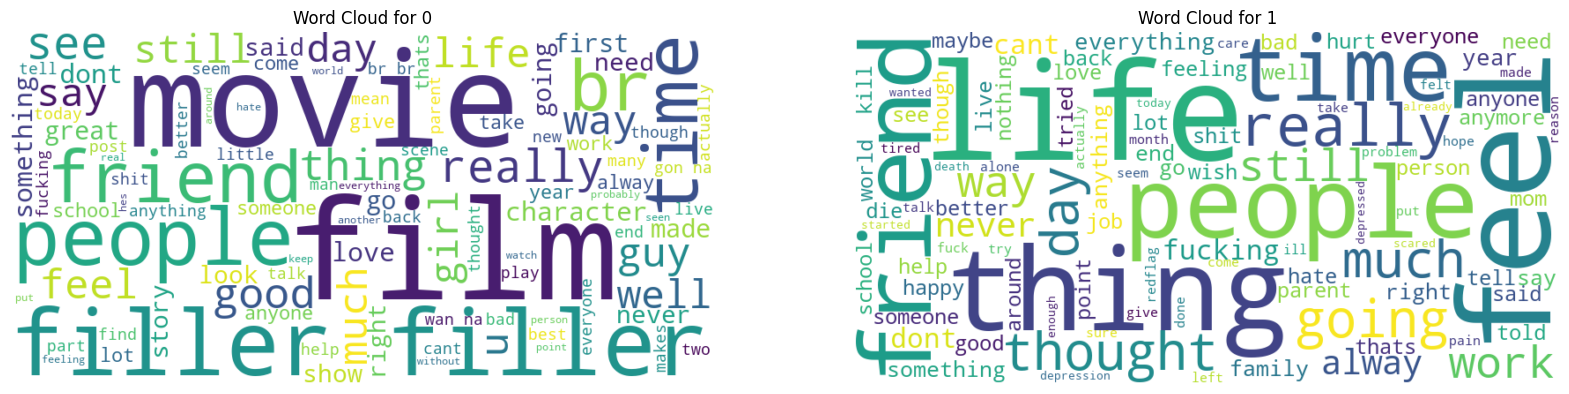

In [89]:
# Generate word clouds after stop word removal
generate_wordclouds(df, 'text_no_stopwords')

### 3.3. World Cloud after Stemming

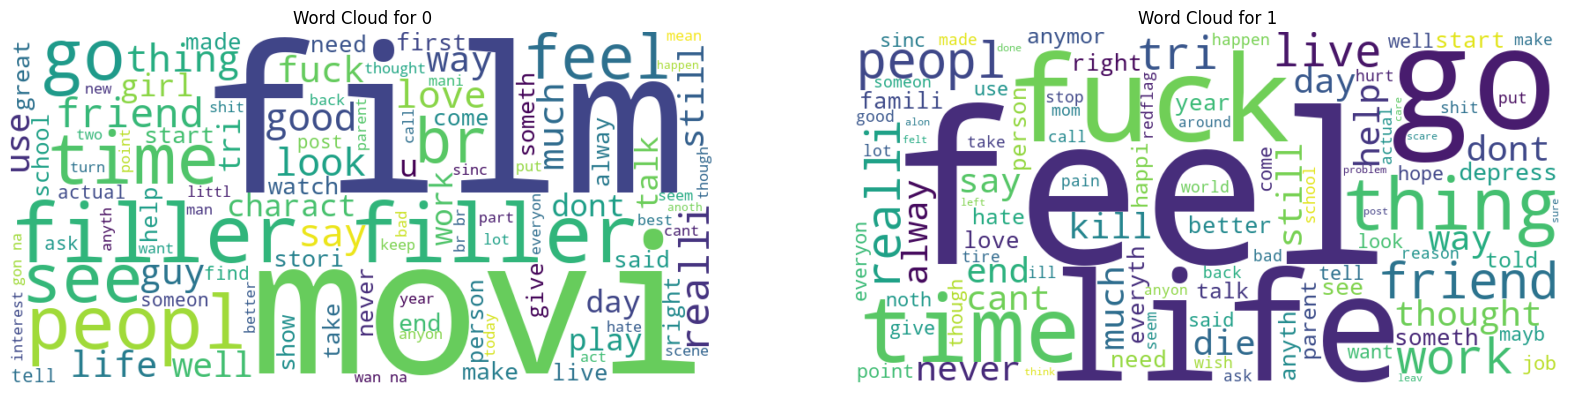

In [90]:
# Generate word clouds after stem
generate_wordclouds(df, 'text_stem')

### 3.4. Using TF-IDF

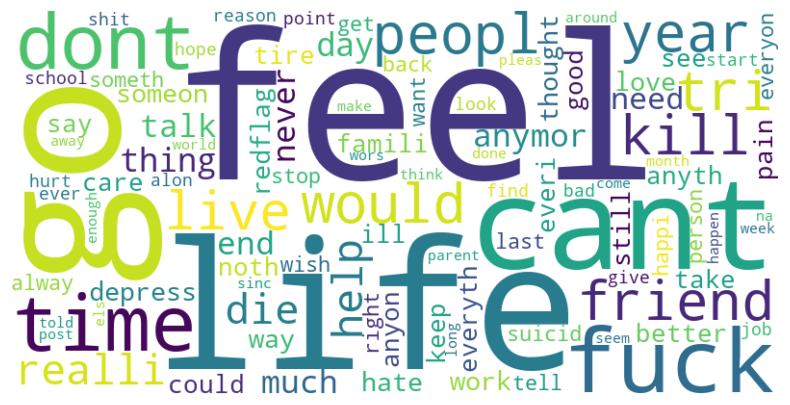

In [91]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_tfidf(df, text_column='text_stem', label_column='label', max_features=1000):
    
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(df[text_column].fillna(""))

    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=vectorizer.get_feature_names_out(),
        index=df.index
    )

    # Add the label column back
    tfidf_df[label_column] = df[label_column].values

    return tfidf_df

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_tfidf_wordcloud(tfidf_df, max_words=100, background_color="white", colormap="viridis", width=800, height=400):

    # Sumar los valores TF-IDF por palabra en todo el corpus
    word_tfidf = tfidf_df.drop(columns=['label'], errors='ignore').sum().to_dict()

    # Generar la nube de palabras
    wordcloud = WordCloud(
        width=width, height=height, 
        background_color=background_color, 
        colormap=colormap, 
        max_words=max_words
    ).generate_from_frequencies(word_tfidf)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


df_filtered = df[df["label"] == 1]

# Example usage:
tfidf_df = generate_tfidf(df_filtered, text_column='text_stem', label_column='label')

# Generar la WordCloud basada en el DataFrame de TF-IDF
generate_tfidf_wordcloud(tfidf_df)


### Generating Topics Using LDA

In [92]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Vectorización del texto
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df_filtered['text_stem'])

# Aplicar LDA con 5 temas
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Obtener los términos más representativos de cada tema
words = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    topics[f"Topic {topic_idx+1}"] = top_words

# Mostrar los temas y palabras clave


KeyboardInterrupt: 

In [ ]:
df_topics = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in topics.items()]))
df_topics

  Topic 1 Topic 2 Topic 3  Topic 4 Topic 5
0    fuck    year    feel     feel    year
1    life     mom    life     help  friend
2    feel    time   peopl     dont    life
3    dont    told   thing    think    time
4    hate     dad   think   realli    feel
5     die    live    live     talk  school
6  anymor  famili    make      day    work
7    shit    said     tri      tri   thing
8    live  mother    time     time  realli
9    kill    work     way  thought     job


### Generating Topics with N-GRAMS

In [96]:
# Re-attempt processing n-grams with a more memory-efficient approach

from sklearn.feature_extraction.text import CountVectorizer

# Filter rows where label == 1
df_label_1 = df[df['label'] == 1]

# Extract text data
texts = df_label_1['text'].dropna().tolist()

# Generate n-grams (bigrams and trigrams) with a limited vocabulary size to avoid memory issues
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=10000)  # Limit feature size
X_ngrams = vectorizer.fit_transform(texts)

# Convert sparse matrix to sum of occurrences
ngrams_counts = X_ngrams.sum(axis=0).A1

# Create DataFrame
ngrams_counts_df = pd.DataFrame(
    {'ngram': vectorizer.get_feature_names_out(), 'count': ngrams_counts}
).sort_values(by='count', ascending=False)



ngrams_counts_df

,ngram,count
2246,feel like,4643
3831,im going,1474
1568,dont know,1376
9187,want die,1350
1606,dont want,1158
...,...,...
2415,finally find,14
2408,fight back,14
26,abuse me,14
9943,years long,14


In [97]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA with a limited vocabulary size
num_topics = 10  # Define number of topics

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(X_ngrams)

# Extract top words for each topic
def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_features
    return topics

# Get top words per topic
topics_dict = get_top_words(lda_model, vectorizer.get_feature_names_out(), n_top_words=10)

# Convert to DataFrame
topics_df = pd.DataFrame(topics_dict)

topics_df


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,im tired,feel like,want die,feel like,need help,im going,feel like,feel like,please help,dont know
1,im going,like im,feel like,makes feel,high school,dont want,dont know,im gonna,every day,feel like
2,someone talk,feels like,kill myself,im tired,first time,get better,dont want,mental health,want die,im sorry
3,need someone,feel like im,want kill,kill myself,years ago,im done,like im,im sure,feel like,dont want
4,im scared,even know,die want,good enough,years old,im fucking,know im,know do,help please,think im
5,talk to,feeling like,really want,feels like,year old,want die,feel like im,long time,suicidal thoughts,im going
6,ive tried,every day,im scared,like im,felt like,kill myself,im sure,years ago,help me,ive never
7,im sorry,around me,want die want,long time,help need,cant even,feels like,like that,right now,know anymore
8,know im,dont even,want kill myself,make feel,look forward,it im,suicidal thoughts,feels like,know do,better without
9,cant take,im tired,want live,want live,two years,things get,even though,first time,help please help,would better


**Even though "Madrid" is included as a stopword, it reappears after stemming due to variations in word forms.**



## 4. Exporting Results into a CSV File

Standard Results

In [ ]:
df_final.to_csv("files/text_analysis/text_analysis_final_results.csv", index=False, encoding="utf-8")

NameError: name 'df_final' is not defined

Vectorized Results

In [ ]:
export_tfidf_data(tfidf_df, "files/text_analysis/tfidf_vectorized_text.csv")

TF-IDF vectorized text exported to files/text_analysis/tfidf_vectorized_text.csv
